# Full Cooling Calculation

We are now ready to demonstrate the full cooling calculation, starting from an injection of high-energy electrons and photons, and ending in an integrated ionization and thermal history that results from this injection. 

## Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
import pickle
import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
from darkhistory.spec.spectrum import Spectrum
import darkhistory.history.tla as tla

import darkhistory.low_energy.lowE_electrons as lowE_electrons
import darkhistory.low_energy.lowE_photons as lowE_photons
import time

np.set_printoptions(threshold=np.nan)

## Inputs

The inputs of the code are as follows: 

1. A `Spectrum` or `Spectra` object containing the injected electron spectrum, or the injected electron spectrum as a function of redshift, and/or 

2. A `Spectrum` or `Spectra` object containing the injected photon spectrum, or the injected photon spectrum as a function of redshift.

There are 3 modes of use. For a `Spectrum` input, the spectrum can be interpreted either as a single injection at a particular redshift, and no subsequent injections, or as a spectrum with the redshift dependence factored out, with a continuous injection at every step. For a `Spectra` input, the spectrum at each redshift step is injected. 

We will start with the single injection case here. As an example, we begin with a $\delta$-function injection of two 12 eV electrons at some arbitrary energy, start at redshift $1+z = 2000$. Let's first initialize the spectrum. 

In [3]:
###   Example: 24eV DM decaying into two 12eV photons   ###
rs0 = 2100
d_lnz = 1e-3
dt = d_lnz / phys.hubble(rs0)
m_DM = 2*12

#Energy injection through decay
def dm_injection_rate(rs):
    # Set the desired lifetime here in seconds. 
    tau = 1e19
    return phys.rho_DM*rs**3/tau

tot_inj = dm_injection_rate(rs0)

#Create a delta function spectrum at 12eV
bins = 200
eng = 10**((np.arange(bins)-.7*bins)*(10/bins))
DM_indx = spectools.get_indx(eng,m_DM/2)

eng=np.delete(eng,DM_indx)
eng=np.insert(eng,DM_indx,m_DM/2);

Ns = np.zeros(bins)
lowengelec_spec_final = Spectrum(eng, Ns, rs0, spec_type='N')
lowengphot_spec_final = Spectrum(eng, Ns, rs0, spec_type='N')

# Old Method

Given the final low energy electron and photon spectra, we can now calculate the fraction of energy that the electrons deposit in heating the IGM(?), lyman-$\alpha$ transitions, ionizing H, ionizing He, and continuum photons.

In [4]:
#The deposition rate is a constant function of z
#%autoreload
lowengphot_spec_final = Spectrum(eng, Ns, rs0, spec_type='N')

dt = d_lnz / phys.hubble(rs0)
tot_inj = dm_injection_rate(rs0)
eng_inj = tot_inj * dt / (phys.nB * rs0**3)
lowengphot_spec_final.N[DM_indx] += 2 * eng_inj / m_DM
x = np.array([1, 0, 0])

Method = 'old'
num = lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, x , tot_inj, dt, method=Method)[1]
print(lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, x , tot_inj, dt, method=Method))

def f_H_exc(rs, xHI, xHeI, xHeII):
    return num

# All photons have been deposited
lowengphot_spec_final.N[DM_indx] = 0

[0. 1. 0. 0. 0.]


In [96]:
# Baseline: Case with no DM
def f_H_ion(rs, xHI, xHeI, xHeII):
    return 0
def f_heating(rs, xHI, xHeI, xHeII):
    return 0
def f_H_exc(rs, xHI, xHeI, xHeII):
    return 1

def dm_injection_rate(rs):
    return 0

init_cond = [phys.TCMB(rs0), 1e-12, 0, 0]

sol_noDM = tla.get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, spacings, reion_switch=False)

Ts_noDM = sol_noDM[:,0]
xe_noDM = sol_noDM[:,1]

In [5]:
%%prun
#t0 = time.time()

%autoreload
Method = "old"

# Redshifts at which the solution will be found
latest = np.log(rs0) - np.floor(np.log(rs0)/d_lnz)*d_lnz
rs_vec = np.append(
    np.exp(np.flipud(np.arange(latest,np.log(rs0)+d_lnz,d_lnz))),
    1
)
if(rs_vec[0] != rs0):
    sys.exit()

# Where the ionization and temperature histories will be stored
xe = np.zeros(len(rs_vec))
Ts = np.zeros(len(rs_vec))
f_hist = np.zeros(len(rs_vec))

# ionization and heating fractions are zero in this model
def f_H_ion(rs, xHI, xHeI, xHeII):
    return np.zeros_like(rs)

def f_heating(rs, xHI, xHeI, xHeII):
    return np.zeros_like(rs)

tot_inj = dm_injection_rate(rs0)
eng_inj = tot_inj * dt / (phys.nB * rs0**3)
lowengphot_spec_final.N[DM_indx] += 2 * eng_inj / m_DM
x = np.array([1, 0, 0])
num = lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, x , tot_inj, dt, method=Method)[1]
print(lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, x , tot_inj, dt, method=Method))

def f_H_exc(rs, xHI, xHeI, xHeII):
    return num

# Initial conditions
rs = rs0

T = phys.TCMB(rs)
Ts[0] = T

chi = phys.nHe/phys.nH
xHI = 0
xHII = 1-xHI
xHeI = chi
xHeII = 0
xHeIII = chi - xHeI - xHeII
xe[0] = xHII + xHeII + 2*xHeIII

t0 = time.time()
for k in np.arange(5):#np.arange(len(rs_vec)-1):
    init_cond = [T, xHII, xHeII, xHeIII]

    dt = d_lnz / phys.hubble(rs)
    tot_inj = dm_injection_rate(rs)
    eng_inj = tot_inj * dt / (phys.nB * rs**3)
    lowengphot_spec_final.N[DM_indx] += 2 * eng_inj / m_DM

    #def f_H_exc(rs, xHI, xHeI, xHeII):
        #x = np.array([xHI,xHeI,xHeII])
        #lowengphot_spec_final.rs = rs
        #return lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, x , tot_inj, dt, method=Method)[1]

    rs_new = rs_vec[k+1]
    rs_step = np.array([rs, rs_new])

    if rs_new < 16.1:
        Reion_switch = False
    else:
        Reion_switch = False
            
    # Evaluation of the tla
    sol = tla.get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, rs_step, reion_switch=Reion_switch)
    
    # All photons have been deposited
    lowengphot_spec_final.N[DM_indx] = 0
    
    #Update temperature and ionization fractions
    T, xHII, xHeII, xHeIII = sol[1]
    
    xHI = 1 - xHII
    xHeI = chi - xHeII - xHeIII
    xe[k+1] = xHII + xHeII + 2*xHeIII
    Ts[k+1] = T
    f_hist[k+1] = f_H_exc(rs, xHI, xHeI, xHeII)
    
    rs = rs_new
    
t1 = time.time()
print("Total Time: ", t1-t0)

[0. 1. 0. 0. 0.]


/Users/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Total Time:  3.1747641563415527
 

# Faster Implementation of Old Method

In [33]:
t0 = time.time()

rs0 = 3000
d_lnz = 1e-3
dt = d_lnz / phys.hubble(rs0)
m_DM = 2*12

#Energy injection through decay
def dm_injection_rate(rs):
    # Set the desired lifetime here in seconds. 
    tau = 1e25
    return 0*phys.rho_DM*rs**3/tau

# ionization and heating fractions are zero in this model
def f_H_ion(rs, xHI, xHeI, xHeII):
    return np.zeros_like(rs)

def f_heating(rs, xHI, xHeI, xHeII):
    return np.zeros_like(rs)

def f_H_exc(rs, xHI, xHeI, xHeII):
    return 1

# Initial conditions
T = phys.TCMB(rs0)

chi = phys.nHe/phys.nH
xHI = 0
xHII = 1-xHI
xHeI = chi
xHeII = 0
xHeIII = chi - xHeI - xHeII

init_cond = [T, xHII, xHeII, xHeIII]

# Redshifts at which I would like the solution
latest = np.log(rs0) - np.floor(np.log(rs0)/d_lnz)*d_lnz
rs_vec = np.append(
    np.exp(np.flipud(np.arange(latest,np.log(rs0)+d_lnz,d_lnz))),
    1
)

Reion_switch = False
# Evaluation of the tla
sol = tla.get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, rs_vec, reion_switch=Reion_switch)
t1 = time.time()
print("time: ", t1-t0)

time:  0.3199899196624756


In [34]:
#Ts_noDM = Ts
#xe_noDM = xe
Ts_noDM = sol[:,0]
xe_noDM = sol[:,1]

In [622]:
Ts_old = Ts
xe_old = xe

In [32]:
Ts = sol[:,0]
xe = sol[:,1]

[1, 3000, 1e-08, 1.0]

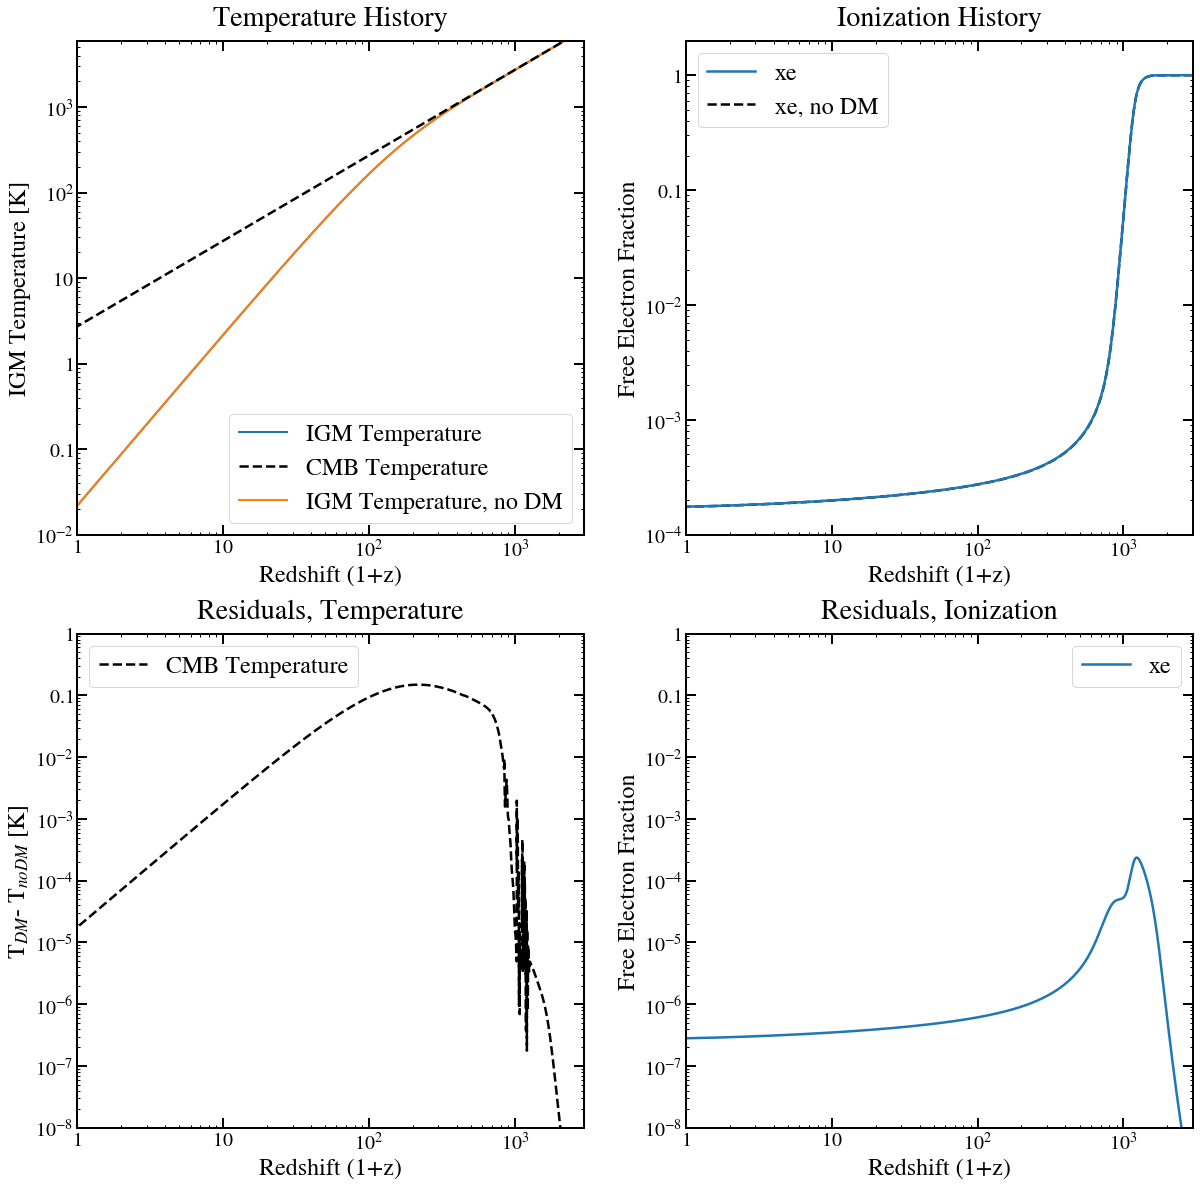

In [35]:
plt.figure(figsize=(20,20))


#---- Plot 1 ----#
ax = plt.subplot(2,2,1)
#plt.rc('text', usetex=False)

T_IGM, = plt.plot(rs_vec, Ts/phys.kB, linewidth=2, label='IGM Temperature')
T_IGM_noDM, = plt.plot(rs_vec, Ts_noDM/phys.kB, linewidth=2, label='IGM Temperature, no DM')
T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[T_IGM, T_CMB, T_IGM_noDM], 
           fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Temperature History', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('IGM Temperature [K]',fontsize=24)
plt.axis([1, rs0, 1e-2, 6e3])


#---- Plot 2 ----#
ax = plt.subplot(2,2,2)
plt.rc('text', usetex=False)

xe_noDM_plt, = plt.plot(rs_vec, xe_noDM, 'k--', label='xe, no DM')
xe_DM_plt, = plt.plot(rs_vec, xe, label='xe')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[xe_DM_plt, xe_noDM_plt], 
           fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Ionization History', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('Free Electron Fraction',fontsize=24)
plt.axis([1, rs0, 1e-4, 2])


#---- Plot 3 ----#
ax = plt.subplot(2,2,3)

T_residual, = plt.plot(rs_vec, np.abs(Ts-Ts_noDM)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[T_residual], 
           fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Residuals, Temperature', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('T$_{DM}$- T$_{noDM}$ [K]',fontsize=24)
plt.axis([1, rs0, 1e-8, 1e0])


#---- Plot 4 ----#
ax = plt.subplot(2,2,4)
#plt.rc('text', usetex=False)

xe_residual_plt, = plt.plot(rs_vec, np.abs(xe - xe_noDM), label='xe')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[xe_residual_plt], 
           fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Residuals, Ionization', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('Free Electron Fraction',fontsize=24)
plt.axis([1, rs0, 1e-8, 1e0])

In [29]:
print((Ts_noDM-Ts)/phys.kB)

[ 0.00000000e+00 -7.47478196e-06  2.01141410e-07 -1.87359818e-07
  4.34241696e-06  1.43495719e-06  3.68223723e-05  5.04256086e-05
  4.89001074e-07  1.93163882e-08 -6.64040301e-08 -3.05416796e-07
  9.23369867e-07 -1.80047961e-05  3.69351844e-05  2.96020139e-08
  2.25237616e-08  2.52898714e-08  2.57581905e-08  2.65279858e-08
  2.69653842e-08  2.75966808e-08  2.82762910e-08  2.88554090e-08
  2.94983009e-08  3.01688925e-08  3.08253121e-08  3.15010572e-08
  3.21768022e-08  3.29227629e-08  3.36526191e-08  3.44114634e-08
  3.51728845e-08  3.59529867e-08  3.67517702e-08  3.75627931e-08
  3.83970065e-08  3.92473244e-08  4.01156793e-08  4.10020713e-08
  4.19065003e-08  4.28270339e-08  4.37752672e-08  4.47441142e-08
  4.57335751e-08  4.67423613e-08  4.77672520e-08  4.88114682e-08
  4.98750097e-08  5.09662510e-08  5.20871246e-08  5.32408514e-08
  5.44139036e-08  5.55991952e-08  5.67999471e-08  5.80142269e-08
  5.92613598e-08  6.05522970e-08  6.18883267e-08  6.32778235e-08
  6.46866456e-08  6.60838

# New Method

### With Backreaction

Given the final low energy electron and photon spectra, we can now calculate the fraction of energy that the electrons deposit in heating the IGM(?), lyman-$\alpha$ transitions, ionizing H, ionizing He, and continuum photons.

In [128]:
rs0 = 2000
d_lnz = 1e-3
dt = d_lnz / phys.hubble(rs0)
m_DM = 2*12

#Energy injection through decay
def dm_injection_rate(rs):
    # Set the desired lifetime here in seconds. 
    tau = 1e25
    return phys.rho_DM*rs**3/tau

tot_inj = dm_injection_rate(rs0)

#Create a delta function spectrum at 12eV
bins = 200
eng = 10**((np.arange(bins)-.7*bins)*(10/bins))
DM_indx = spectools.get_indx(eng,m_DM/2)

eng=np.delete(eng,DM_indx)
eng=np.insert(eng,DM_indx,m_DM/2);

Ns = np.zeros(bins)
lowengelec_spec_final = Spectrum(eng, Ns, rs0, spec_type='N')
lowengphot_spec_final = Spectrum(eng, Ns, rs0, spec_type='N')

In [127]:
print(spacings[:5])

[2100.         2097.90104965 2095.8041972  2093.70944056 2091.61677762]


In [130]:
%%prun
#t0 = time.time()


%autoreload
Method = "new"

# Redshifts at which the solution will be found
left = np.log(rs0) - np.floor(np.log(rs0)/d_lnz)*d_lnz
rs_vec = np.append(
    np.exp(np.flipud(np.arange(left,np.log(rs0)+d_lnz,d_lnz))),
    1
)
if rs_vec[0] > rs0:
    if np.abs(rs_vec[1] - rs0) < 1e-7:
        rs_vec = rs_vec[1:]
    else:
        rs_vec = np.insert(rs_vec[1:],0,rs0)

print("First rs: ",rs_vec[0])

# Where the ionization and temperature histories will be stored
xe = np.zeros(len(rs_vec))
Ts = np.zeros(len(rs_vec))
f_hist = np.zeros(len(rs_vec))

# ionization and heating fractions are zero in this model
def f_H_ion(rs, xHI, xHeI, xHeII):
    return np.zeros_like(rs)

def f_heating(rs, xHI, xHeI, xHeII):
    return np.zeros_like(rs)

# Initial conditions
rs = rs0

T = phys.TCMB(rs)
Ts[0] = T

chi = phys.nHe/phys.nH
xHI = 0
xHII = 1-xHI
xHeI = chi
xHeII = 0
xHeIII = chi - xHeI - xHeII
xe[0] = xHII + xHeII + 2*xHeIII

t0 = time.time()
for k in np.arange(5): #np.arange(len(rs_vec)-1)+1:
    init_cond = [T, xHII, xHeII, xHeIII]

    dt = d_lnz / phys.hubble(rs)
    tot_inj = dm_injection_rate(rs)
    eng_inj = tot_inj * dt / (phys.nB * rs**3)
    lowengphot_spec_final.N[DM_indx] += 2 * eng_inj / m_DM
    
    f_hist[k] = f_H_exc(rs, xHI, xHeI, xHeII)

    def f_H_exc(rs, xHI, xHeI, xHeII):
        x = np.array([xHI,xHeI,xHeII])
        lowengphot_spec_final.rs = rs
        return lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, x , tot_inj, dt, method=Method)[1]

    rs_new = rs_vec[k+1]
    rs_step = np.array([rs, rs_new])

    if rs_new < 16.1:
        Reion_switch = False
    else:
        Reion_switch = False
            
    # Evaluation of the tla
    sol = tla.get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, rs_step, reion_switch=Reion_switch)
    lowengphot_spec_final.rs = rs_vec[k]
    
    #print('initial redshift ', lowengphot_spec_final.rs)
    #print(rs_new)
    # No photons deposit, all redshift
    lowengphot_spec_final.redshift(rs_new)
    
    #Update temperature and ionization fractions
    T, xHII, xHeII, xHeIII = sol[1]
    
    xHI = 1 - xHII
    xHeI = chi - xHeII - xHeIII
    xe[k+1] = xHII + xHeII + 2*xHeIII
    Ts[k+1] = T
    
    rs = rs_new
    
t1 = time.time()
print("Total Time: ", t1-t0)

First rs:  1999.9999999999998
Total Time:  2.9957358837127686
 

In [113]:
print(f_hist)
#print(lowengphot_spec_final.N)
print(tot_inj, f_H_exc(1, xHI, xHeI, xHeII))

[ 0.00000000e+00  0.00000000e+00 -1.68844232e-05 -2.04654463e-05
 -1.81295280e-05 -8.57594881e-06  1.03199351e-05  4.14100558e-05
  8.81975170e-05  1.54813403e-04  2.46032286e-04  3.67313359e-04
  5.24858624e-04  7.25683032e-04  9.77694687e-04  1.28978384e-03
  1.67191938e-03  2.13525612e-03  2.69224937e-03  3.35677963e-03
  4.14428803e-03  5.07192349e-03  6.15869921e-03  7.42566619e-03
  8.89609760e-03  1.05956887e-02  1.25527724e-02  1.47985489e-02
  1.73673455e-02  2.02968765e-02  2.36285367e-02  2.74077127e-02
  3.16841182e-02  3.65121527e-02  4.19512858e-02  4.80664701e-02
  5.49285815e-02  6.26148907e-02  7.12095653e-02  8.08042064e-02
  9.14984189e-02  1.03400419e-01  1.16627679e-01  1.31307611e-01
  1.47578348e-01  1.65589350e-01  1.85502339e-01  2.07492143e-01
  2.31747556e-01  2.58472312e-01  2.87886046e-01  3.20225300e-01
  3.55744600e-01  3.94717560e-01  4.37438013e-01  4.84221212e-01
  5.35405005e-01  5.91351075e-01  6.52446178e-01  7.19103406e-01
  7.91763442e-01  8.70895

In [81]:
Ts_old = Ts
xe_old = xe
f_old = f_hist

[1, 2000, 1e-08, 2]

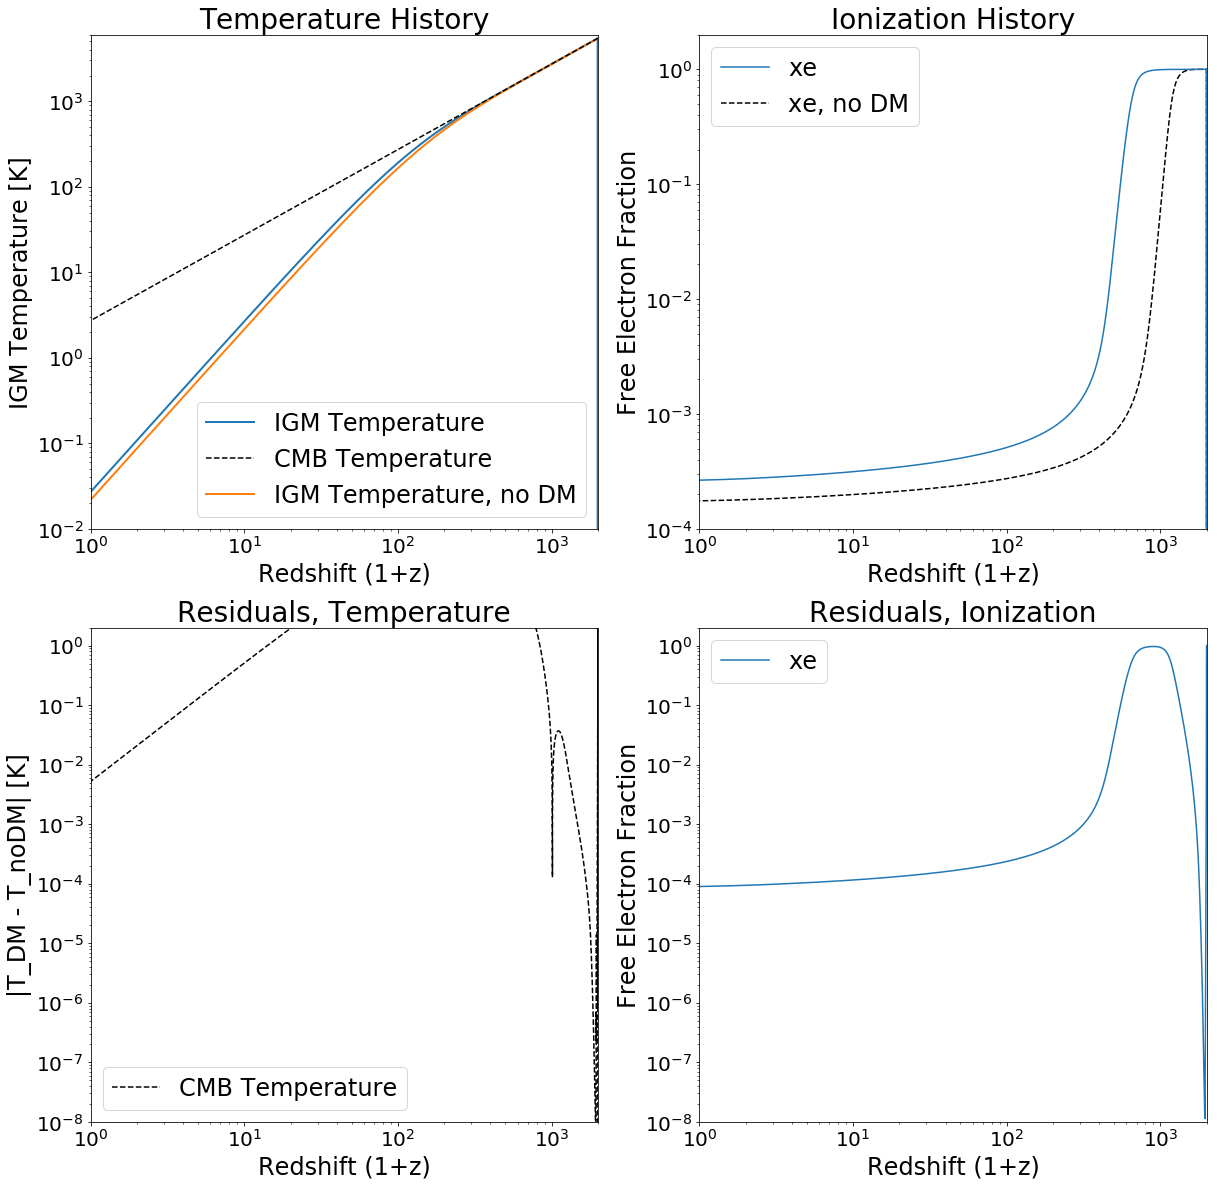

In [114]:
plt.figure(figsize=(20,20))


#---- Plot 1 ----#
ax = plt.subplot(2,2,1)
#plt.rc('text', usetex=False)

T_IGM, = plt.plot(spacings, Ts/phys.kB, linewidth=2, label='IGM Temperature')
T_IGM_noDM, = plt.plot(spacings, Ts_noDM/phys.kB, linewidth=2, label='IGM Temperature, no DM')
T_CMB, = plt.plot(spacings, phys.TCMB(spacings)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[T_IGM, T_CMB, T_IGM_noDM], 
           fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Temperature History', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('IGM Temperature [K]',fontsize=24)
plt.axis([1, rs0, 1e-2, 6e3])


#---- Plot 2 ----#
ax = plt.subplot(2,2,2)
#plt.rc('text', usetex=False)

xe_noDM_plt, = plt.plot(spacings, xe_noDM, 'k--', label='xe, no DM')
xe_DM_plt, = plt.plot(spacings, xe, label='xe')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[xe_DM_plt, xe_noDM_plt], 
           fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Ionization History', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('Free Electron Fraction',fontsize=24)
plt.axis([1, rs0, 1e-4, 2])


#---- Plot 3 ----#
ax = plt.subplot(2,2,3)

T_residual, = plt.plot(spacings, np.abs(Ts-Ts_noDM)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[T_residual], 
           fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Residuals, Temperature', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('|T_DM - T_noDM| [K]',fontsize=24)
plt.axis([1, rs0, 1e-8, 2])


#---- Plot 4 ----#
ax = plt.subplot(2,2,4)
#plt.rc('text', usetex=False)

xe_residual_plt, = plt.plot(spacings, np.abs(xe - xe_noDM), label='xe')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[xe_residual_plt], 
           fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Residuals, Ionization', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('Free Electron Fraction',fontsize=24)
plt.axis([1, rs0, 1e-8, 2])

### Without Backreaction

In [47]:
Method = "new"

def dm_injection_rate(rs):
    # Set the desired lifetime here in seconds. 
    tau = 1e25
    return phys.rho_DM*rs**3/tau

lowengphot_spec_final = Spectrum(eng, Ns, rs0, spec_type='N')

# Redshifts at which the solution will be found
left = np.log(rs0) - np.floor(np.log(rs0)/d_lnz)*d_lnz
rs_vec = np.append(
    np.exp(np.flipud(np.arange(left,np.log(rs0)+d_lnz,d_lnz))),
    1
)

if rs_vec[0] > rs0:
    if np.abs(rs_vec[1] - rs0) < 1e-7:
        rs_vec = rs_vec[1:]
    else:
        rs_vec = np.insert(rs_vec[1:],0,rs0)

print(rs_vec[0])
        
if(np.abs(rs_vec[0] - rs0) > 1e-6):
    print("Not starting at correct initial rs, exiting...")
    sys.exit()

#pre-computing f(z)'s
t0 = time.time()
for k in np.arange(len(rs_vec)-1):
    rs = rs_vec[k]
    dt = d_lnz / phys.hubble(rs)
    tot_inj = dm_injection_rate(rs)
    eng_inj = tot_inj * dt / (phys.nB * rs**3)
    lowengphot_spec_final.N[DM_indx] += 2 * eng_inj / m_DM
    
    rs_new = rs_vec[k+1]
    lowengphot_spec_final.redshift(rs_new)

print(lowengphot_spec_final.N)
print(lowengphot_spec_final.N[DM_indx:DM_indx+11])

# Where the ionization and temperature histories will be stored
xe = np.zeros(len(rs_vec))
Ts = np.zeros(len(rs_vec))
f_hist = np.zeros(len(rs_vec))

# ionization and heating fractions are zero in this model
def f_H_ion(rs, xHI, xHeI, xHeII):
    return np.zeros_like(rs)

def f_heating(rs, xHI, xHeI, xHeII):
    return np.zeros_like(rs)

# Initial conditions
rs = rs0

T = phys.TCMB(rs)
Ts[0] = T

chi = phys.nHe/phys.nH
xHI = 0
xHII = 1-xHI
xHeI = chi
xHeII = 0
xHeIII = chi - xHeI - xHeII
xe[0] = xHII + xHeII + 2*xHeIII

t1 = time.time()
print("Total Time: ", t1-t0)

2999.9999999999977
[3.07161725e-24 6.91561270e-24 1.54744187e-23 3.44114578e-23
 7.60469207e-23 1.67006997e-22 3.64457313e-22 7.90318190e-22
 1.70288293e-21 3.64568511e-21 7.75477076e-21 1.63884533e-20
 3.44088187e-20 7.17708021e-20 1.48715206e-19 3.06108683e-19
 6.25880787e-19 1.27111883e-18 2.56414132e-18 5.13737910e-18
 1.02227457e-17 2.02023587e-17 3.96485532e-17 7.72725756e-17
 1.49547141e-16 2.87387127e-16 5.48371209e-16 1.03891897e-15
 1.95420384e-15 3.64939241e-15 6.76573620e-15 1.24518692e-14
 2.27488876e-14 4.12546583e-14 7.42598522e-14 1.32673579e-13
 2.35258381e-13 4.14015964e-13 7.23071860e-13 1.25319700e-12
 2.15532097e-12 3.67824460e-12 6.22854735e-12 1.04648281e-11
 1.74444975e-11 2.88501454e-11 4.73350869e-11 7.70454159e-11
 1.24400502e-10 1.99247515e-10 3.16550828e-10 4.98837067e-10
 7.79694374e-10 1.20872370e-09 1.85846379e-09 2.83396279e-09
 4.28584928e-09 6.42796399e-09 9.56084662e-09 1.41026232e-08
 2.06290973e-08 2.99250946e-08 4.30493265e-08 6.14151916e-08
 8.68

# Scratch Work

In [383]:
rs_vec[rs_vec > 16.1]

array([ 3000.       ,  2997.0014995])

In [ ]:
%autoreload
import darkhistory.low_energy.lowE_photons as lowE_photons
Method = "new"
x = np.array([xHI,xHeI,xHeII])
tmp=lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, x , tot_inj, dt, method=Method)
dLam_dnu = phys.get_dLam2s_dnu()
print(tmp)

In [335]:
from scipy import integrate
T = phys.TCMB(rs0)
def Boltz(E):
    return np.exp(-E/phys.kB/T)
def E_Boltz(E):
    return E*np.exp(-E/phys.kB/T)


#Ns = np.array([integrate.quad(Boltz,low,high)[0] for low,high in zip(tmp[:-1], tmp[1:])])

#CMB_spec = Spectrum(eng, Ns, rs0, spec_type='N')
#print(sum(CMB_spec.N),integrate.quad(Boltz,tmp[0],tmp[400]),phys.kB*T*(Boltz(tmp[0])-Boltz(tmp[400])))


bounds=spectools.get_bin_bound(eng)

point = spectools.get_indx(bounds, phys.lya_eng-eng[0])
#print(point)
mid = spectools.get_indx(bounds, phys.lya_eng/2)
complement = np.zeros(mid)
f_nu = lowengphot_spec_final.dNdE * phys.c**3 / (8 * np.pi * (eng/phys.hbar)**2)

for k in np.arange(mid):
    while (phys.lya_eng - eng[k]) < bounds[point]:
        point -= 1
    complement[k] = f_nu[point]
        #indices[k] = point
            
print(bounds[mid],bounds[mid+1])
#print(np.nonzero(complement))
#print(phys.lya_eng - eng[np.nonzero(complement)],phys.lya_eng - eng[603],bounds[801],bounds[802])
#print(tmp[775:803])
#print(eng[775],tmp[775],tmp[776])


5.06990708275 5.18800038929


In [336]:
diffs = (np.append(bounds[1:mid],phys.lya_eng/2)-np.insert(bounds[1:mid],0,0))/(2*np.pi*phys.hbar)
Lam = phys.get_dLam2s_dnu()
rates = Lam(eng[:mid]/(2 * np.pi * phys.hbar))
print(np.sum(rates*diffs),phys.lya_eng/2)
print(np.sum(diffs)/phys.lya_freq)
print(integrate.quad(Lam,0,phys.lya_freq/2)[0])

boltz = Boltz(eng[:mid])
boltz_complement = Boltz(phys.lya_eng - eng[:mid])

#Numerical Integral
np.sum(
    diffs*(f_nu[:mid] + boltz)*(complement[:mid] + boltz_complement) * rates
)/phys.width_2s1s-Boltz(phys.lya_eng)

8.22994013092 5.1021346987500005
0.5
8.230000000000272


0.0

21.425235664750588
21.3312464137


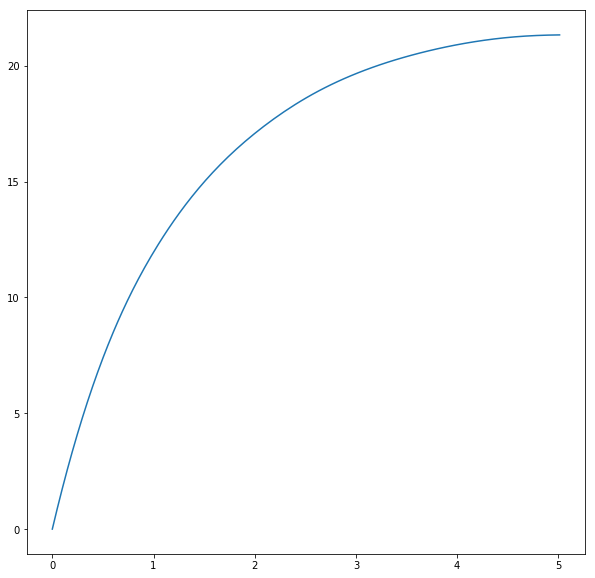

In [329]:
plt.plot(eng[:mid],rates)
print(9*phys.alpha**6 * phys.rydberg / (2**10 * 2 * np.pi * phys.hbar) * 4.907)
print(rates[mid-1])
#plt.plot()
plt.show()

In [333]:
%autoreload
eng = 10**((np.arange(1000)-300)*(1/100))
import matplotlib.pyplot as plt
import darkhistory.spec.spectools as spectools
T=300
beta = 1/T/phys.kB
def f_EQ(eng, beta):
    return np.exp(-beta*eng)
tmp_spec = spectools.discretize(eng,f_EQ,beta)
h = 2 * np.pi * phys.hbar
right=spectools.get_indx(eng,phys.lya_eng)
f_E = tmp_spec.dNdE[:right]
#print(f_E*np.flip(f_E,0) * np.exp(beta*phys.lya_eng))
#plt.plot(eng[indx:],f_EQ(eng[indx:],T),'r--',eng[indx:],tmp_spec.dNdE[indx:],'g^')

In [62]:
tmp=np.delete(eng,indx)
tmp=np.insert(tmp,indx,m_DM/2);
print(tmp[indx-1:indx+2])
print(eng[indx-1:indx+2])

[ 10.96478196  11.2         11.48153621]
[ 10.96478196  11.22018454  11.48153621]


In [56]:
# WORRIES: (1) These f_c(z) functions are not optimized
#          (2) I have switched from xe to xHII
#          (3) Both compute_dep_inj_ratio functions assume that Spectrum.N returns number density per unit time
#          (4) lowE_photons.compute_dep_inj_ratio needs [n_H,n_HeI,n_HeII] as input, not x_HII.
#          (5) Can photons contribute to heating?  Heating of what, IGM?

rs0=3000
rs_final = 1
xHII = .5
xHeI = 0
xHeII = 0
Method = "ion"

def f_H_ion(rs, xHI, xHeI, xHeII):
    n = np.array([xHI,xHeI,xHeII])*phys.nH*(rs**3)
    photon = lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, n, tot_inj, method=Method)[2]
    electron = lowE_electrons.compute_dep_inj_ratio(lowengelec_spec_final, xHII, tot_inj)[2]
    return electron + photon

def f_H_exc(rs, xHI, xHeI, xHeII):
    n = np.array([xHI,xHeI,xHeII])*phys.nH*(rs**3)
    photon = lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final, n , tot_inj, method=Method)[1]
    electron = lowE_electrons.compute_dep_inj_ratio(lowengelec_spec_final, xHII, tot_inj)[1]
    return electron + photon

def f_heating(rs, xHI, xHeI, xHeII):
    return lowE_electrons.compute_dep_inj_ratio(lowengelec_spec_final, xHII, tot_inj)[0]

# Initialize the redshift at which we want the solution. 
rs_vec = np.flipud(1 + np.arange(rs_final,rs0,1))

# Set the initial conditions. The initial temperature is the CMB temperature, 
# and the initial free electron fraction is 1. Strictly speaking, the code
# changes 1 to 1 - 1e-12, as otherwise y is infinite.
init_cond = [phys.TCMB(rs0), 1, 0, 0]

# Obtain the solution
soln = tla.get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, rs_vec, reion_switch=False)
print(soln[-10:,0]/phys.kB)

[  3295.87724568   3808.57837014   4460.35722941   5307.87614393
   6440.16805266   8003.39975759  10249.97632068  13640.62994315
  19058.98657169  28198.62910868]


[1, 3000.0, 0.0001, 2]

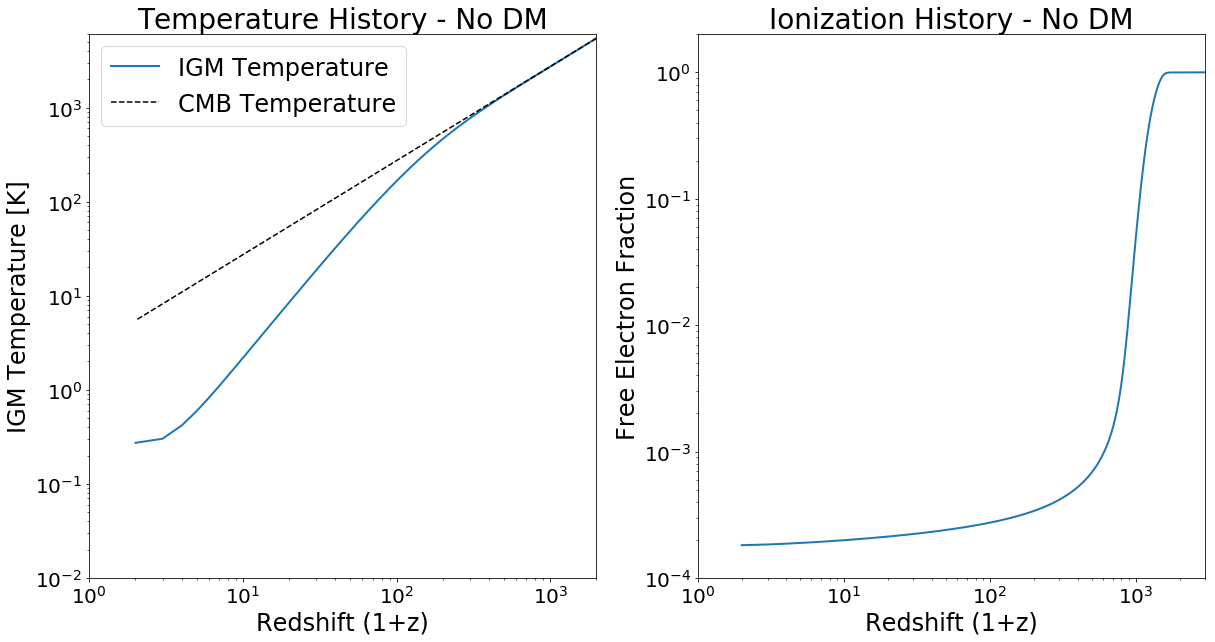

In [19]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
#plt.rc('text', usetex=False)

T_IGM, = plt.plot(rs_vec, soln[:,0]/phys.kB, linewidth=2, label='IGM Temperature')
T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[T_IGM, T_CMB], 
           fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Temperature History - No DM', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('IGM Temperature [K]',fontsize=24)
plt.axis([1, 2e3, 1e-2, 6e3])

ax = plt.subplot(1,2,2)
#plt.rc('text', usetex=False)

plt.plot(rs_vec, soln[:,1], linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Ionization History - No DM', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('Free Electron Fraction',fontsize=24)
plt.axis([1, 3e3, 1e-4, 2])